This notebook demonstrates the model trained on the data provided for common task

**WorkFlow**

* Load the data and create dataframe for train data and validation data as train_df and val_df
* Create PyTorch Dataset
* Define two model ConvNeuralNetwork and PretrainedModel
* Define train_utils class having function for Loss, Optimizer, Scheduler and Score
* Define Train class having function for train, validation and train_loop
* Training of Model

In [1]:
# importing necessary library
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from tqdm import tqdm
import timm

# importing torch_libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CFG:
    lr = 0.0002
    batch_size = 64
    num_classes = 3
    target_col="target"
    epochs = 10
    seed = 42
    num_workers = 2
    transform = False
    weight_decay = 1e-2
    num_workers=2
    train=True
    debug=False
    metric_type="roc_auc"
    scheduler_type = "StepLR"
    optimizer_type = "Adam"
    loss_type = "CrossEntropyLoss"
    max_grad_norm = 1000
    lr_max = 4e-4
    epochs_warmup = 1.0
    model_name = "tf_efficientnet_b4_ns"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Loading of one data of each type for visulization
data_1 = np.load('/kaggle/input/gsocdeeplense/dataset/train/no/10.npy')
data_2 = np.load('/kaggle/input/gsocdeeplense/dataset/train/no/1.npy')
data_3 = np.load('/kaggle/input/gsocdeeplense/dataset/train/vort/1.npy')


data_1

array([[[0.01233046, 0.01479655, 0.01849568, ..., 0.00986436,
         0.00616523, 0.01479655],
        [0.01726264, 0.0135635 , 0.01109741, ..., 0.01109741,
         0.01602959, 0.00863132],
        [0.01479655, 0.01726264, 0.01109741, ..., 0.00616523,
         0.01726264, 0.01109741],
        ...,
        [0.01109741, 0.00986436, 0.0135635 , ..., 0.01479655,
         0.01109741, 0.01972873],
        [0.01726264, 0.01233046, 0.01479655, ..., 0.00739827,
         0.00739827, 0.01972873],
        [0.00739827, 0.00986436, 0.01109741, ..., 0.00616523,
         0.01109741, 0.0135635 ]]])

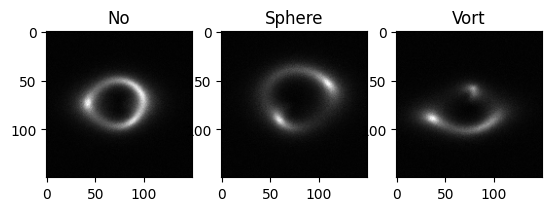

In [5]:
# Plotting the images
data_1 = np.squeeze(data_1)
data_2 = np.squeeze(data_2)
data_3 = np.squeeze(data_3)
plt.subplot(1, 3, 1)
plt.imshow(data_1, cmap="gray")
plt.title("No")
plt.subplot(1, 3, 2)
plt.imshow(data_2, cmap="gray")
plt.title("Sphere")
plt.subplot(1, 3, 3)
plt.title("Vort")
plt.imshow(data_3, cmap="gray")

In [6]:
root_dir = '/kaggle/input/gsocdeeplense/dataset'
dir_train = root_dir+'/train'
dir_val = root_dir+'/val'

In [7]:
# Defining the path 
path_no_train = os.listdir('/kaggle/input/gsocdeeplense/dataset/train/no')
path_sphere_train = os.listdir('/kaggle/input/gsocdeeplense/dataset/train/sphere')
path_vort_train = os.listdir('/kaggle/input/gsocdeeplense/dataset/train/vort')

path_no_val = os.listdir('/kaggle/input/gsocdeeplense/dataset/val/no')
path_sphere_val = os.listdir('/kaggle/input/gsocdeeplense/dataset/val/sphere')
path_vort_val = os.listdir('/kaggle/input/gsocdeeplense/dataset/val/vort')

In [8]:
# Helper Function to create dataframe for train and validation
def data_helper(dir, d_type='train'):
    df = pd.DataFrame()
    target = []
    data_path = []

    if d_type=='train':
        path_1 = path_no_train
        path_2 = path_sphere_train
        path_3 = path_vort_train
    else:
        path_1 = path_no_val
        path_2 = path_sphere_val
        path_3 = path_vort_val

    for i in range(len(path_1)):
        target.append(0)
        data_path.append(dir+'/no/'+path_1[i])
    for i in range(len(path_2)):
        target.append(1)
        data_path.append(dir+'/sphere/'+path_2[i])
    for i in range(len(path_3)):
        target.append(2)
        data_path.append(dir+'/vort/'+path_3[i])

    df['target'] = target
    df['data_path'] = data_path
    df = df.sample(frac=1)
    return df

In [9]:
# Trainig and Validation DataFrame
train_df = data_helper(dir_train)
val_df = data_helper(dir_val, 'val')

In [10]:
# If Debug is set to true and then it reduce the size of data to check the implementation immediatly
if CFG.debug==True:
    train_df = train_df[:10]
    val_df = val_df[:10]

In [11]:
# Pytorch dataset creation
class CustomDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df['data_path']
        image = np.load(image_path.iloc[idx]).astype(np.float32)
        labels = self.df['target'].iloc[idx]
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']
        return torch.tensor(image), torch.tensor(labels)

In [12]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
# Checking dataset
dataa = CustomDataset(train_df)
img, labels = dataa[0]
img.shape

torch.Size([1, 150, 150])

In [14]:
# Custom CNN Model
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(18496, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
# Pretrained model class using EfficientNet-B0
class PretrainedModel(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.model = timm.create_model(self.model_name, pretrained=self.pretrained, in_chans=1)
        clsf = self.model.default_cfg['classifier']
        n_features = self.model._modules[clsf].in_features
        self.model._modules[clsf] = nn.Identity()  # Remove the original classifier
        self.fc = nn.Linear(n_features, CFG.num_classes)  # Add a new classifier layer

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [16]:
# Class containing loss, optimizer, scheduler and score method
class train_utils():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG
    
    # Defining the Loss Function
    @property
    def get_criterion(self):
        if self.CFG.loss_type == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif self.CFG.loss_type == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        return criterion
    
    # Defining the Score Function
    def get_score(self, y_true, y_pred):
        if self.CFG.metric_type == "accuracy_score":
            score =  accuracy_score(y_true, y_pred)
        elif self.CFG.metric_type == "roc_auc":
            score =  roc_auc_score(y_true, y_pred, multi_class="ovr")
        return score
    
    # Defining the Optimizer Function
    def get_optimizer(self, model):
        if self.CFG.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay, amsgrad=False)
        if self.CFG.optimizer_type == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay)
        return optimizer
    
    # Defining the Scheduler Function
    def get_scheduler(self, optimizer):
        if self.CFG.scheduler_type == "StepLR":
            scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)
        return scheduler

In [17]:
class Train():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG  
        
    def train_fn(self, train_loader, model, criterion, optimizer, epoch, scheduler, device):
        model.train() # switch to training mode
        running_loss = AverageMeter()
        count = 0
        for (images, labels) in tqdm(train_loader, desc="Train"):
            images = images.to(device)
            labels = labels.to(device)
            y_preds = model(images)
            bs = images.size(0)

            loss = criterion(y_preds, labels)
            running_loss.update(loss.item(), bs)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        return running_loss.avg

    def valid_fn(self, valid_loader, model, criterion, device):
        model.eval() # switch to evaluation mode
        preds = []
        running_loss = AverageMeter()
        count = 0

        for (images, labels) in tqdm(valid_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)
            bs = images.size(0)

            # compute loss
            with torch.no_grad():
                y_preds = model(images)
            loss = criterion(y_preds, labels)
            running_loss.update(loss.item(), bs)
            count += labels.shape[0]
            # record accuracy
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        predictions = np.concatenate(preds)

        return (running_loss.avg), predictions
    
    # Train loop
    def train_loop(self, train_data, valid_data):

        # create dataset
        train_dataset = CustomDataset(train_data)
        valid_dataset = CustomDataset(valid_data)

        # create dataloader
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.CFG.batch_size, shuffle=True, 
                                  num_workers=self.CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=self.CFG.batch_size, shuffle=False, 
                                  num_workers=self.CFG.num_workers, pin_memory=True, drop_last=False)

        # create model and transfer to device
    #     model = ConvNeuralNet(CFG.num_classes)
        model = PretrainedModel(pretrained=True)
        model.to(device)
        
        # Creating object of train_utils
        train_obj = train_utils(self.CFG)
        # select optimizer, scheduler and criterion
        optimizer = train_obj.get_optimizer(model)
        scheduler = train_obj.get_scheduler(optimizer)
        criterion = train_obj.get_criterion

        best_score = -1.0
        best_loss = np.inf

        # start training
        val_pred_df = pd.DataFrame()
        for epoch in range(self.CFG.epochs):
            print("Epoch:", epoch+1)
            # train
            avg_loss = self.train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            # validation
            avg_val_loss, preds = self.valid_fn(valid_loader, model, criterion, device)

            #valid_labels = valid_folds[CFG.target_col].values
            valid_labels = valid_data['target']

            scheduler.step()

            # scoring
            score = train_obj.get_score(valid_labels, preds)
            print("roc_auc_score: ", score)

            # code for saving the best model
            if score > best_score:
                print('Score Improved')
                best_score = score
                print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f}')
                torch.save({'model': model.state_dict(), 
                            'preds': preds,
                            'optimizer': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict()},
                            './'+f'{self.CFG.model_name}_best.pth')
                
        val_pred_df['actual_target'] = valid_labels
        val_pred_df['pred_target'] = list(preds)
        
        return val_pred_df  

In [18]:
# main
def main():
    
    if CFG.train: 
        # train
        train = Train(CFG)
        df = train.train_loop(train_df, val_df)
    return df

In [19]:
if __name__ == '__main__':
    pred_df = main()

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Epoch: 1


Validation: 100%|██████████| 118/118 [00:19<00:00,  6.16it/s]


roc_auc_score:  0.9354962933333333
Score Improved
Epoch 1 - Save Best Score: 0.9355
Epoch: 2


Validation: 100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


roc_auc_score:  0.9721753599999999
Score Improved
Epoch 2 - Save Best Score: 0.9722
Epoch: 3


Validation: 100%|██████████| 118/118 [00:14<00:00,  8.42it/s]


roc_auc_score:  0.9820799333333333
Score Improved
Epoch 3 - Save Best Score: 0.9821
Epoch: 4


Validation: 100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


roc_auc_score:  0.98368792
Score Improved
Epoch 4 - Save Best Score: 0.9837
Epoch: 5


Validation: 100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


roc_auc_score:  0.9847091200000001
Score Improved
Epoch 5 - Save Best Score: 0.9847
Epoch: 6


Validation: 100%|██████████| 118/118 [00:14<00:00,  8.40it/s]


roc_auc_score:  0.98470552
Epoch: 7


Validation: 100%|██████████| 118/118 [00:14<00:00,  8.43it/s]


roc_auc_score:  0.9849637066666667
Score Improved
Epoch 7 - Save Best Score: 0.9850
Epoch: 8


Validation: 100%|██████████| 118/118 [00:14<00:00,  8.43it/s]


roc_auc_score:  0.9849951333333333
Score Improved
Epoch 8 - Save Best Score: 0.9850
Epoch: 9


Validation: 100%|██████████| 118/118 [00:14<00:00,  8.41it/s]


roc_auc_score:  0.9848692533333333
Epoch: 10


Validation: 100%|██████████| 118/118 [00:14<00:00,  8.42it/s]

roc_auc_score:  0.9848588533333333


In [20]:
# Calculation of Probability for target class and exact class to plot roc_curve and confusion matrix

pred_df 
proba = []
pred_label = []
for i in pred_df['pred_target']:
    proba.append(max(np.array(i)))
    pred_label.append(np.array(i).argmax())
pred_df['pred_proba'] = proba
pred_df['pred_target'] = pred_label

pred_df.head()

,actual_target,pred_target,pred_proba
6195,2,2,0.997078
6591,2,2,0.999909
4583,1,1,0.933572
140,0,0,0.983899
3467,1,0,0.793999


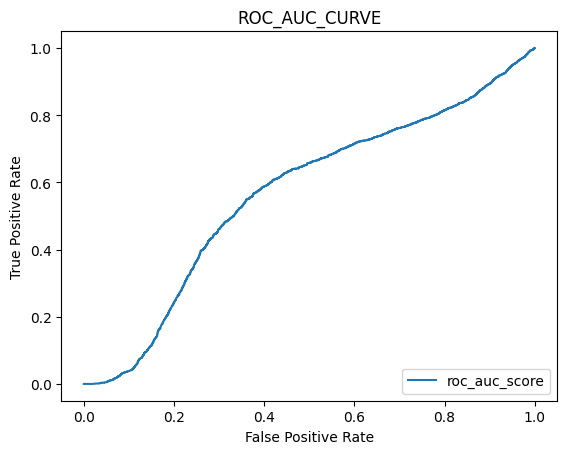

In [21]:
fpr, tpr, _ = roc_curve(pred_df['actual_target'],  pred_df['pred_proba'], pos_label=1)

#create ROC curve
plt.plot(fpr,tpr, label='roc_auc_score')
plt.title("ROC_AUC_CURVE")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

<Axes: >

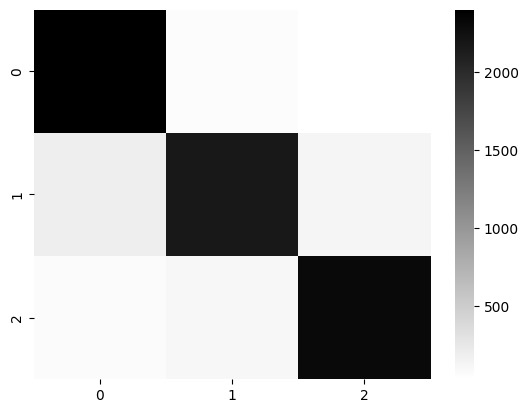

In [22]:
# Plotting Confusion Matrix
m = confusion_matrix(pred_df['actual_target'], pred_df['pred_target'])
sns.heatmap(m, cmap='binary')